<h4><b>Load Libraries</b></h4>

In [25]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.stats as st
import warnings
import yfinance as yf


<h4><b>Import Data</b></h4>
<p>The 1-day(daily) OHLCV data of EURUSD price is stored in a Yahoo Finance API. The data ranges from January 2004 to today.</p>

In [26]:
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)


class Statistics(object):
    def __init__(self, symbol, time_frame):
        self.symbol = symbol
        self.time_frame = time_frame
        self.data = self.load_data()

    # Load data
    def load_data(self):
        ticket = yf.Ticker(f"{self.symbol}")
        dataset = ticket.history(period="max", interval=self.time_frame, auto_adjust=True).drop(columns=["Volume", "Dividends", "Stock Splits"]).rename(
            columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close'})  # periods: “1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”
        dataset["time"] = dataset.index
        self.data = dataset
        return pd.DataFrame(self.data)

    def feature_engeering(self):
        dataset = self.load_data()
        dataset["amplitude"] = (dataset["high"].rolling(3).max() - dataset["low"].rolling(3).min())
        dataset["daily_return"] = dataset["close"].pct_change(periods=1)
        dataset["hour"] = dataset["time"].dt.hour
        dataset["day"] = dataset["time"].dt.day
        dataset["dayofweek"] = dataset["time"].dt.dayofweek
        dataset["dayname"] = dataset["time"].dt.day_name()
        dataset["weekday"] = dataset["time"].dt.weekday
        dataset["dayofyear"] = dataset["time"].dt.dayofyear # Monday=0, Sunday=6.
        dataset["month"] = dataset["time"].dt.month
        dataset["mean_month"] = dataset["close"].rolling(window=30).mean()
        dataset["positive_negative"] = np.select([dataset["daily_return"] >= 0, dataset["daily_return"] < 0], [1, -1])
        dataset["above_below_mean"] = np.select([dataset["close"] > dataset["close"].rolling(window=30).mean(), dataset["daily_return"] < dataset["close"].rolling(window=30).mean()], [1, -1])
        dataset["volatility"] = dataset["daily_return"].rolling(window=252).std() * np.sqrt(252)
        return pd.DataFrame(dataset).dropna()


symbols = ["AVGO"]
time_frames = ['1d']
for symbol in symbols:
    print(f'\n {symbol}')
    for time_frame in time_frames:
        strategytester = Statistics(symbol, time_frame)
        dataset = strategytester.feature_engeering()
        print(dataset)



 AVGO
                  open        high         low       close       time  \
Date                                                                    
2010-08-06   16.760192   16.886488   16.633896   16.782480 2010-08-06   
2010-08-09   16.849346   17.035075   16.700762   17.012787 2010-08-09   
2010-08-10   16.775055   16.953355   16.492747   16.567038 2010-08-10   
2010-08-11   15.259511   15.415522   14.323435   15.029205 2010-08-11   
2010-08-12   15.192645   15.519527   15.006916   15.162928 2010-08-12   
...                ...         ...         ...         ...        ...   
2022-10-19  433.230011  438.299988  430.880005  435.299988 2022-10-19   
2022-10-20  435.130005  442.190002  428.140015  430.299988 2022-10-20   
2022-10-21  432.089996  450.660004  429.170013  449.730011 2022-10-21   
2022-10-24  452.730011  458.790009  451.109985  456.519989 2022-10-24   
2022-10-25  457.989990  464.260010  456.959991  460.070007 2022-10-25   

            amplitude  daily_return  hour  

<h4>Gaussian Distribution</h4>
<p>A distribution of data refers to the shape it has when you graph it</p>

Mean: [ 16.78248024  17.01278687  16.56703758 ... 449.73001099 456.51998901
 460.07000732], 
Var: [1. 1. 1. ... 1. 1. 1.], 
Skew: [0. 0. 0. ... 0. 0. 0.], 
Kurt: [0. 0. 0. ... 0. 0. 0.]


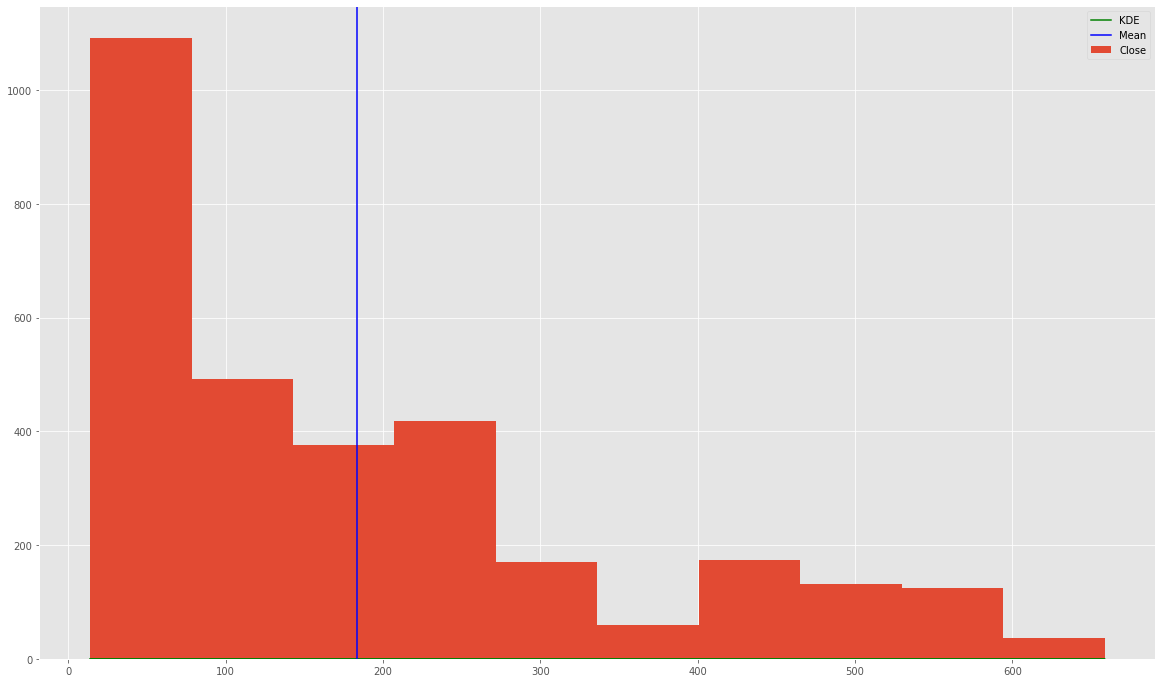

In [44]:
mean, var, skew, kurt = norm.stats(dataset["close"], moments='mvsk')
print(f"Mean: {mean}, \nVar: {var}, \nSkew: {skew}, \nKurt: {kurt}")

# Representation of a kernel-density estimate using Gaussian kernels.
kde = st.gaussian_kde(dataset["close"])
xvals = np.linspace(dataset["close"].min(), dataset["close"].max())
yvals = kde(xvals)
mode = xvals[yvals.argmax()]
plt.figure(figsize=(20, 12))
plt.hist(dataset["close"], label="Close")
plt.plot(xvals, yvals, label="KDE", color="g")
plt.axvline(x=dataset["close"].mean(), color="b", label="Mean")
plt.legend()
plt.show()